In [1]:
%load_ext autoreload
%autoreload 2
%cd ~/Research/Sriram/DeepSetRNN

import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import os
import string
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import logging
import os
import importlib

from src import convert_dot_format

DATA_PATH='data/MIMIC3database'

/home/minh/Research/Sriram/DeepSetRNN


In [2]:
logging.info("starting logger")
_LOGGER = logging.getLogger('MIMIC_seq_model')
_LOGGER.setLevel(logging.DEBUG)

# Preprocessing Data

In [3]:
top_n = 100 #should be the same as before
diagnoses_procedures_df = pd.read_csv('data/MIMIC3database/processed/ICD9_diagnoses_procedures_mimic_idx_sentences_top_100_sorted.csv', index_col=0)

#converting sentences to a single column
diagnoses_procedures_df['DIAGNOSES_SENTENCES'] = diagnoses_procedures_df[['0_diagnoses', '1_diagnoses',
       '2_diagnoses', '3_diagnoses', '4_diagnoses', '5_diagnoses',
       '6_diagnoses', '7_diagnoses', '8_diagnoses', '9_diagnoses',
       '10_diagnoses', '11_diagnoses', '12_diagnoses', '13_diagnoses',
       '14_diagnoses', '15_diagnoses', '16_diagnoses', '17_diagnoses',
       '18_diagnoses', '19_diagnoses', '20_diagnoses', '21_diagnoses', '22',
       '23', '24', '25', '26', '27', '28', '29', '30', '31']].values.tolist()

diagnoses_procedures_df['PROCEDURES_SENTENCES'] = diagnoses_procedures_df[
    ['0_procedures', '1_procedures', '2_procedures', '3_procedures',
       '4_procedures', '5_procedures', '6_procedures', '7_procedures',
       '8_procedures', '9_procedures', '10_procedures', '11_procedures',
       '12_procedures', '13_procedures', '14_procedures', '15_procedures',
       '16_procedures', '17_procedures', '18_procedures', '19_procedures',
       '20_procedures', '21_procedures']].values.tolist()

diagnoses_procedures_df.drop(labels=['0_diagnoses', '1_diagnoses',
       '2_diagnoses', '3_diagnoses', '4_diagnoses', '5_diagnoses',
       '6_diagnoses', '7_diagnoses', '8_diagnoses', '9_diagnoses',
       '10_diagnoses', '11_diagnoses', '12_diagnoses', '13_diagnoses',
       '14_diagnoses', '15_diagnoses', '16_diagnoses', '17_diagnoses',
       '18_diagnoses', '19_diagnoses', '20_diagnoses', '21_diagnoses', '22',
       '23', '24', '25', '26', '27', '28', '29', '30', '31'], axis=1, inplace=True)

diagnoses_procedures_df.drop(labels=['0_procedures', '1_procedures', '2_procedures', '3_procedures',
       '4_procedures', '5_procedures', '6_procedures', '7_procedures',
       '8_procedures', '9_procedures', '10_procedures', '11_procedures',
       '12_procedures', '13_procedures', '14_procedures', '15_procedures',
       '16_procedures', '17_procedures', '18_procedures', '19_procedures',
       '20_procedures', '21_procedures'], axis=1, inplace=True)

diagnoses_procedures_df.to_csv("data/MIMIC3database/processed/ICD9_diagnoses_procedures_mimic_idx_sentences_top_100_sorted_concat.csv")

In [4]:
diagnoses_counts = diagnoses_procedures_df['ICD9_CODE_diagnoses'].value_counts()
procedures_counts = diagnoses_procedures_df['ICD9_CODE_procedures'].value_counts()

diagnoses_set = set(diagnoses_counts.keys()[:top_n])
procedures_set = set(procedures_counts.keys()[:top_n])

diagnoses_idx_map = {}
for i, code in enumerate(diagnoses_counts.keys()[:top_n]):
    diagnoses_idx_map[code] = i

data = list(diagnoses_procedures_df.groupby(['SUBJECT_ID']))
data = [(subject_id, list(subject_data.groupby(['HADM_ID', 'ADMITTIME']))) for subject_id, subject_data in data]


def get_onehot_vector(indices, top_n):
    prediction = np.zeros(top_n, dtype='float32')
    prediction[indices] = 1
    return prediction

all_inputs = []
all_outputs = []
for _, subject in data:
    input_series = []
    output_series = []
    for _, timestep in subject:
        timestep = timestep[timestep['ICD9_CODE_diagnoses'].isin(diagnoses_set)
                           | timestep['ICD9_CODE_procedures'].isin(procedures_set)]
        indices = [diagnoses_idx_map[key] for key in timestep['ICD9_CODE_diagnoses'] if key in diagnoses_set]
        if len(timestep) > 0:
            input_series.append((np.stack(timestep['DIAGNOSES_SENTENCES'],axis=0), np.stack(timestep['PROCEDURES_SENTENCES'],axis=0)))
            output_series.append(get_onehot_vector(indices, top_n))
    if len(input_series) > 0 and len(output_series):
        all_inputs.append(input_series)
        all_outputs.append(np.array(output_series))


# all_outputs = []

# def get_onehot_vector(indices, top_n):
#     prediction = np.zeros(top_n, dtype='float32')
#     prediction[indices] = 1
#     return prediction

# for _, subject in data:
#     series = []
#     for _, timestep in subject:
#         indices = [diagnoses_idx_map[key] for key in timestep['ICD9_CODE_diagnoses'] \
#                   if key in diagnoses_set]
#         if len(timestep) > 0:
#             series.append(get_onehot_vector(indices, top_n))
#     if len(series) > 0:
#         all_outputs.append(np.array(series))

In [5]:
len(all_inputs)

44788

In [6]:
min_len = 3

inputs = list(filter(lambda x : len(x) >= min_len, all_inputs))
outputs = list(filter(lambda x: len(x) >= min_len, all_outputs))

n_seq = len(inputs)

split = int(n_seq*0.8)
train_inputs = inputs[:split]
train_outputs =  outputs[:split]

test_inputs = inputs[split:n_seq]
test_outputs = outputs[split:n_seq]

In [7]:
word_embedding = pd.read_csv('data/embeddings/w2vModel1Gram9Jan2019_mimic_only.txt', index_col=0)
word_embedding.drop('0',axis=1,inplace=True)
word_embedding = torch.tensor(word_embedding.astype('float32').values)

# Training Models

In [8]:
#global objects
training_loss_map = {}
model_map = {}

In [9]:
######LSTM MODEL#####
from src.model.mimic_deepset import SetSequenceModel

hidden_dim=[1000,100]
n_epoch = 10
freeze_embedding = True
lr = 0.1
momentum = 0.9

_LOGGER.handlers = [
    h for h in _LOGGER.handlers if not isinstance(h, logging.StreamHandler)]
model_name = "DeepSetLSTM_top_{}_{}hd_{}".format(top_n, hidden_dim, n_epoch)
fh = logging.FileHandler('logs/MIMIC3/{}.log'.format(model_name))
fh.setLevel(logging.DEBUG)
_LOGGER.addHandler(fh)

loss_fn = nn.BCEWithLogitsLoss()
model = SetSequenceModel(hidden_dim=hidden_dim, n_class=top_n,embedding=word_embedding, freeze_embedding=freeze_embedding)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

model_map[model_name] = model

#initial test loss
test_losses = []
for sequence, target in zip(test_inputs, test_outputs):
    model.hidden = model.init_hidden()
    logits = model(sequence)
    loss = loss_fn(logits[:-1],torch.tensor(target[1:]))
    test_losses.append(loss.data)
_LOGGER.info("Initial Validation Loss: {}".format(np.mean(test_losses)))

#training model
training_losses = []
for epoch in range(n_epoch):
    curr_losses = []
    for sequence, target in zip(train_inputs,
                                train_outputs):
        model.zero_grad()
        model.hidden = model.init_hidden()
        
        logits = model(sequence)
        loss = loss_fn(logits[1:], torch.tensor(target[1:]))
        curr_losses.append(loss.data)
        loss.backward()
        optimizer.step()
    mean_loss = np.mean(curr_losses)
    training_losses.append(mean_loss)
    _LOGGER.info("epoch {}: {}".format(epoch, mean_loss))
    
#saving model
torch.save(model, 'models/MIMIC3/{}.pt'.format(model_name))

#final validation loss
test_losses = []
for sequence, target in zip(test_inputs, test_outputs):
    model.hidden = model.init_hidden()
    logits = model(sequence)
    loss = loss_fn(logits[:-1],torch.tensor(target[1:]))
    test_losses.append(loss.data)
_LOGGER.info("final validation Loss: {}".format(np.mean(test_losses)))

training_loss_map[model_name] = training_losses

INFO:MIMIC_seq_model:Initial Validation Loss: 0.6947639584541321
INFO:MIMIC_seq_model:epoch 0: 0.21705271303653717
INFO:MIMIC_seq_model:epoch 1: 0.176101416349411
INFO:MIMIC_seq_model:epoch 2: 0.15209880471229553
INFO:MIMIC_seq_model:epoch 3: 0.13539540767669678
INFO:MIMIC_seq_model:epoch 4: 0.1219571977853775
INFO:MIMIC_seq_model:epoch 5: 0.11010400950908661
INFO:MIMIC_seq_model:epoch 6: 0.10062946379184723
INFO:MIMIC_seq_model:epoch 7: 0.09195126593112946
INFO:MIMIC_seq_model:epoch 8: 0.08548451215028763
INFO:MIMIC_seq_model:epoch 9: 0.07950246334075928
INFO:MIMIC_seq_model:final validation Loss: 0.3772851824760437


In [10]:
###FULLY CONNECTED MODEL#####
from src.model.mimic_deepset import FullyConnectedNetworkClassifier
hidden_dim=[1000,100]
n_epoch = 10
freeze_embedding = True
lr = 0.1
momentum = 0.9

_LOGGER.handlers = [
    h for h in _LOGGER.handlers if not isinstance(h, logging.StreamHandler)]
model_name = "DeepSetFCN_top_{}_{}hd_{}".format(top_n, hidden_dim, n_epoch)
fh = logging.FileHandler('logs/MIMIC3/{}.log'.format(model_name))
fh.setLevel(logging.DEBUG)
_LOGGER.addHandler(fh)

model = FullyConnectedNetworkClassifier(top_n, word_embedding, [1000, 100], freeze_embedding)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

model_map[model_name] = model

test_losses = []
for sequence, target in zip(test_inputs, test_outputs):
    logits = model(sequence)
    
    loss = loss_fn(logits[:-1],torch.tensor(target[1:]))
    test_losses.append(loss.data)
_LOGGER.info("Iniital Validation Loss: {}".format(np.mean(test_losses)))

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=.9)
training_losses = []

for epoch in range(n_epoch):
    curr_losses = []
    for sequence, target in zip(train_inputs,
                                train_outputs):
        model.zero_grad()
        
        logits = model(sequence)
        loss = loss_fn(logits[1:], torch.tensor(target[1:]))
        curr_losses.append(loss.data)
        loss.backward()
        optimizer.step()
    mean_loss = np.mean(curr_losses)
    training_losses.append(mean_loss)
    _LOGGER.info("epoch {}: {}".format(epoch, mean_loss))
    
test_losses = []
for sequence, target in zip(test_inputs, test_outputs):
    logits = model(sequence)
    
    loss = loss_fn(logits[:-1],torch.tensor(target[1:]))
    test_losses.append(loss.data)
_LOGGER.info("Validation Loss: {}".format(np.mean(test_losses)))

torch.save(model, 'models/MIMIC3/{}.pt'.format(model_name))
training_loss_map[model_name] = training_losses

INFO:MIMIC_seq_model:Iniital Validation Loss: 0.6947373151779175
INFO:MIMIC_seq_model:epoch 0: 0.21611672639846802
INFO:MIMIC_seq_model:epoch 1: 0.16527464985847473
INFO:MIMIC_seq_model:epoch 2: 0.14302779734134674
INFO:MIMIC_seq_model:epoch 3: 0.12695586681365967
INFO:MIMIC_seq_model:epoch 4: 0.11604571342468262
INFO:MIMIC_seq_model:epoch 5: 0.10867258906364441
INFO:MIMIC_seq_model:epoch 6: 0.10280148684978485
INFO:MIMIC_seq_model:epoch 7: 0.0978354662656784
INFO:MIMIC_seq_model:epoch 8: 0.0938636064529419
INFO:MIMIC_seq_model:epoch 9: 0.09056731313467026
INFO:MIMIC_seq_model:Validation Loss: 0.3773224949836731


In [11]:
####LOG REG CLASSIFIER#####
from src.model.mimic_deepset import EmbeddedLogRegClassifier

n_epoch = 10
freeze_embedding = True
lr = 0.1
momentum = 0.9

_LOGGER.handlers = [
    h for h in _LOGGER.handlers if not isinstance(h, logging.StreamHandler)]
model_name = "DeepSetLogReg_top_{}_{}hd_{}".format(top_n, hidden_dim, n_epoch)
fh = logging.FileHandler('logs/MIMIC3/{}.log'.format(model_name))
fh.setLevel(logging.DEBUG)
_LOGGER.addHandler(fh)

model = EmbeddedLogRegClassifier(top_n, word_embedding, freeze_embedding)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

model_map[model_name] = model

test_losses = []
for sequence, target in zip(test_inputs, test_outputs):
    logits = model(sequence)
    
    loss = loss_fn(logits[:-1],torch.tensor(target[1:]))
    test_losses.append(loss.data)
_LOGGER.info("Iniital Validation Loss: {}".format(np.mean(test_losses)))

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=.9)
training_losses = []

for epoch in range(n_epoch):
    curr_losses = []
    for sequence, target in zip(train_inputs,
                                train_outputs):
        model.zero_grad()
        
        logits = model(sequence)
        loss = loss_fn(logits[1:], torch.tensor(target[1:]))
        curr_losses.append(loss.data)
        loss.backward()
        optimizer.step()
    mean_loss = np.mean(curr_losses)
    training_losses.append(mean_loss)
    _LOGGER.info("epoch {}: {}".format(epoch, mean_loss))
    
test_losses = []
for sequence, target in zip(test_inputs, test_outputs):
    logits = model(sequence)
    
    loss = loss_fn(logits[:-1],torch.tensor(target[1:]))
    test_losses.append(loss.data)
_LOGGER.info("Validation Loss: {}".format(np.mean(test_losses)))

torch.save(model, 'models/MIMIC3/{}.pt'.format(model_name))
training_loss_map[model_name] = training_losses

INFO:MIMIC_seq_model:Iniital Validation Loss: 0.7326723337173462
INFO:MIMIC_seq_model:epoch 0: 0.3223177492618561
INFO:MIMIC_seq_model:epoch 1: 0.2328720986843109
INFO:MIMIC_seq_model:epoch 2: 0.19394516944885254
INFO:MIMIC_seq_model:epoch 3: 0.1704840064048767
INFO:MIMIC_seq_model:epoch 4: 0.15402795374393463
INFO:MIMIC_seq_model:epoch 5: 0.13763654232025146
INFO:MIMIC_seq_model:epoch 6: 0.12685678899288177
INFO:MIMIC_seq_model:epoch 7: 0.12328938394784927
INFO:MIMIC_seq_model:epoch 8: 0.1134151741862297
INFO:MIMIC_seq_model:epoch 9: 0.10385029017925262
INFO:MIMIC_seq_model:Validation Loss: 0.6155065298080444


# Analysis

In [12]:
_LOGGER.handlers = [
    h for h in _LOGGER.handlers if not isinstance(h, logging.StreamHandler)]
fh = logging.FileHandler('logs/MIMIC3/embedded_models_analysis.log')
fh.setLevel(logging.DEBUG)
_LOGGER.addHandler(fh)

In [13]:
test_prediction_map = {}
test_logits_map = {}
test_output_map = {}
#preprocessing test outputs
sigmoid = nn.Sigmoid()
for model_name, model in model_map.items():
    all_logits = []
    all_outputs = []
    all_predictions = []
    for sequence, target in zip(test_inputs, test_outputs):    
    
        if 'LSTM' in model_name:
            model.hidden = model.init_hidden()

        logits = model(sequence)

        model_outputs = sigmoid(logits).detach().numpy()
        predictions = model_outputs > 0.5
        predictions = predictions.astype(np.float32)

        all_outputs.append(model_outputs)
        all_logits.append(logits.detach().numpy())
        all_predictions.append(predictions)
    test_prediction_map[model_name] = all_predictions
    test_logits_map[model_name] = all_logits
    test_output_map[model_name] = all_outputs

In [29]:
#precision@k
from src.utils import precision_at_k, bootstrap_CI
k_values = [1,2,3]
for k in k_values:
    for model_name in model_map:
            pk = precision_at_k(test_logits_map[model_name], test_outputs, k)
            _LOGGER.info("{} {}".format(model_name, pk))

INFO:MIMIC_seq_model:DeepSetLSTM_top_100_[1000, 100]hd_10 0.580593466758728
INFO:MIMIC_seq_model:DeepSetFCN_top_100_[1000, 100]hd_10 0.5553631782531738
INFO:MIMIC_seq_model:DeepSetLogReg_top_100_[1000, 100]hd_10 0.5797337889671326
INFO:MIMIC_seq_model:DeepSetLSTM_top_100_[1000, 100]hd_10 0.5457634925842285
INFO:MIMIC_seq_model:DeepSetFCN_top_100_[1000, 100]hd_10 0.5164042115211487
INFO:MIMIC_seq_model:DeepSetLogReg_top_100_[1000, 100]hd_10 0.5471559762954712
INFO:MIMIC_seq_model:DeepSetLSTM_top_100_[1000, 100]hd_10 0.5227649807929993
INFO:MIMIC_seq_model:DeepSetFCN_top_100_[1000, 100]hd_10 0.48298922181129456
INFO:MIMIC_seq_model:DeepSetLogReg_top_100_[1000, 100]hd_10 0.5214715600013733


In [26]:
#precision@k with confidence intervals
from src.utils import precision_at_k, bootstrap_CI
from sklearn.utils import resample

k_values = [1,2,3]
n_bootstrap = 1000

bootstrap_pk_map = {}
pk_CI_map = {}

for k in k_values:
    _LOGGER.info("Computing Precision@{}".format(k))
    for model_name in model_map:
        pk, CI = bootstrap_CI(precision_at_k, {'k':k}, 
                             (test_logits_map[model_name], test_outputs),
                              n_bootstrap)
        bootstrap_pk_map[model_name] = pk
        pk_CI_map[model_name] = CI
        _LOGGER.info("{} {}".format(model_name, CI))

INFO:MIMIC_seq_model:Computing Precision@1
INFO:MIMIC_seq_model:DeepSetLSTM_top_100_[1000, 100]hd_10 (0.5795644814124115, 0.5816598838219635)
INFO:MIMIC_seq_model:DeepSetFCN_top_100_[1000, 100]hd_10 (0.5543641753306767, 0.5565092854389766)
INFO:MIMIC_seq_model:DeepSetLogReg_top_100_[1000, 100]hd_10 (0.5786370515689145, 0.5806707859173525)
INFO:MIMIC_seq_model:Computing Precision@2
INFO:MIMIC_seq_model:DeepSetLSTM_top_100_[1000, 100]hd_10 (0.5457794779418155, 0.5474139338852719)
INFO:MIMIC_seq_model:DeepSetFCN_top_100_[1000, 100]hd_10 (0.5152136137234564, 0.5169255683673029)
INFO:MIMIC_seq_model:DeepSetLogReg_top_100_[1000, 100]hd_10 (0.5467822810717097, 0.5484250524930486)
INFO:MIMIC_seq_model:Computing Precision@3
INFO:MIMIC_seq_model:DeepSetLSTM_top_100_[1000, 100]hd_10 (0.5219945219091077, 0.5234754774042468)
INFO:MIMIC_seq_model:DeepSetFCN_top_100_[1000, 100]hd_10 (0.4818681577816934, 0.48333977659788424)
INFO:MIMIC_seq_model:DeepSetLogReg_top_100_[1000, 100]hd_10 (0.52083059695718

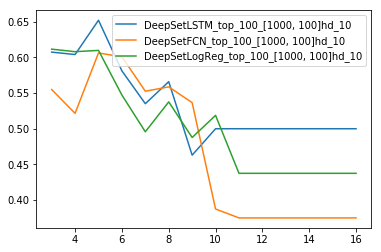

In [25]:
k = 1
pk_vs_len_map = {}

max_len = max(map(len, test_outputs))
for model_name in model_map:
    pks = []
    filtered_logits = test_logits_map[model_name]
    filtered_test_outputs = test_outputs
    
    for filter_len in range(min_len, max_len):
        indices = [i for (i,sequence) in enumerate(filtered_test_outputs) if len(sequence) > filter_len]
        
        filtered_logits = [filtered_logits[i] for i in indices]
        filtered_test_outputs = [filtered_test_outputs[i] for i in indices]
        #print(len(filtered_test_outputs))
        pks.append(precision_at_k(filtered_logits, filtered_test_outputs, k))
    pk_vs_len_map[model_name] = pks
    
max_len = max(map(len, test_outputs))

for model_name, pks in pk_vs_len_map.items():
    plt.plot(np.arange(3,max_len), pks, label=model_name)
plt.legend()

In [31]:
true_labels_flattened = np.concatenate(list((map(lambda x : x.flatten(), test_outputs))))
for model_name in model_map:
    predictions = test_prediction_map[model_name]
    predictions_flattened = np.concatenate(list(map(lambda x : x.flatten(), predictions)))
    _LOGGER.info("{}\n{}".format(model_name,metrics.confusion_matrix(true_labels_flattened, predictions_flattened)))

INFO:MIMIC_seq_model:DeepSetLSTM_top_100_[1000, 100]hd_10
[[153408   1540]
 [  5396   7956]]
INFO:MIMIC_seq_model:DeepSetFCN_top_100_[1000, 100]hd_10
[[153177   1771]
 [  5803   7549]]
INFO:MIMIC_seq_model:DeepSetLogReg_top_100_[1000, 100]hd_10
[[153431   1517]
 [  3690   9662]]


In [ ]:
#AUROC curve


for model_name in model_map:

    
    test_output_map[model_name]